In [ ]:
pip install darts

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
import darts
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, TCNModel, TransformerModel, TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# **Air Passenger Dataset Import**
In this notebook we will compare four different deep learning models using the Air Passenger Dataset. The models are:

* Recurrent Neural Network

* Temporal Convolutional

* Transformer

* Temporal Fusion Transformer

In [3]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

# **Recurrent Neural Networks**
RNNModel is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:

* the previous target value, which will be set to the last known target value for the first prediction, and for all other predictions it will be set to the previous prediction

* the previous hidden state

* the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon n thus is created in n iterations of RNNModel predictions and requires n future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

In [4]:
RecurrentNeuralNetwork = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [ ]:
RecurrentNeuralNetwork.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

Use the best model obtained over training, according to validation loss:

In [6]:
best_RecurrentNeuralNetwork = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)

In [ ]:
backtest_RecurrentNeuralNetwork = best_RecurrentNeuralNetwork.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

In [9]:
def eval_RNN(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()

# **Temporal Convolutional Network**
In the context of forecasting, a Temporal Convolutional Network (TCN) is a neural network architecture that leverages convolutional layers to make predictions on sequential or time series data. TCNs have shown promise in capturing temporal patterns and dependencies in the data, making them suitable for forecasting tasks.

In [10]:
TemporalConvolutionalNetwork = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

In [11]:
ts = AirPassengersDataset().load()
scaler = Scaler()
ts = scaler.fit_transform(
    ts
)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("19580801"))
train_month, val_month = month_series.split_after(pd.Timestamp("19580801"))

In [ ]:
TemporalConvolutionalNetwork.fit(
    series=train,
    past_covariates=train_month,
    val_series=val,
    val_past_covariates=val_month,
    verbose=True,
)

In [ ]:
backtest_TemporalConvolutionalNetwork = TemporalConvolutionalNetwork.historical_forecasts(
    series=ts,
    past_covariates=month_series,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

# **Transformer Model**
In the context of forecasting, the Transformer model can be used to predict future values based on historical time series data. It consists of an encoder-decoder structure, where the encoder processes the input sequence (historical data) and the decoder generates the future predictions.

In [45]:
series = AirPassengersDataset().load().astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [46]:
Transformer = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

In [ ]:
Transformer.fit(series=train_scaled, val_series=val_scaled, verbose=True)

In [48]:
def eval_Transformer(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()

In [49]:
bestTransformer = TransformerModel.load_from_checkpoint(
    model_name="air_transformer", best=True
)

In [ ]:
backtest_series = bestTransformer.historical_forecasts(
    series=series_scaled,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

# **Temporal Fusion Transformer**
In the context of forecasting, the Temporal Fusion Transformer (TFT) is a neural network architecture specifically designed to make accurate predictions on time series data. TFT combines the strengths of the Transformer model and traditional temporal fusion techniques to capture temporal patterns and dependencies effectively.



In [56]:
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [57]:
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [58]:
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
TemporalFusionTransformer = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [ ]:
TemporalFusionTransformer.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

In [60]:
def eval_TFT(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

In [ ]:
backtest_series = TemporalFusionTransformer.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

In [62]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

# **Evaluation**

Predicting: 0it [00:00, ?it/s]

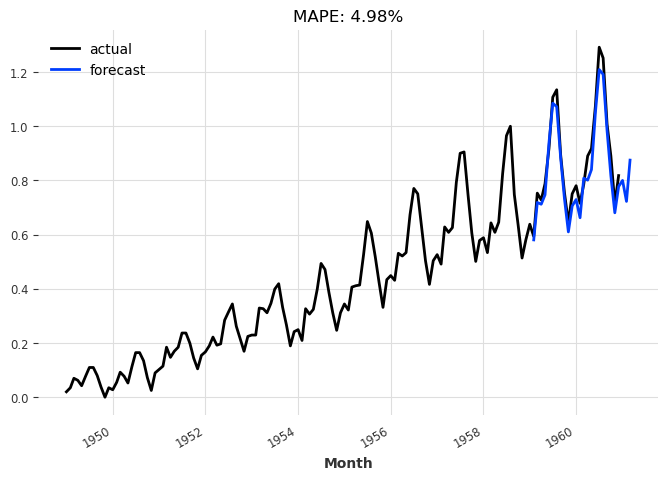

In [41]:
eval_RNN(RecurrentNeuralNetwork)

Predicting: 0it [00:00, ?it/s]

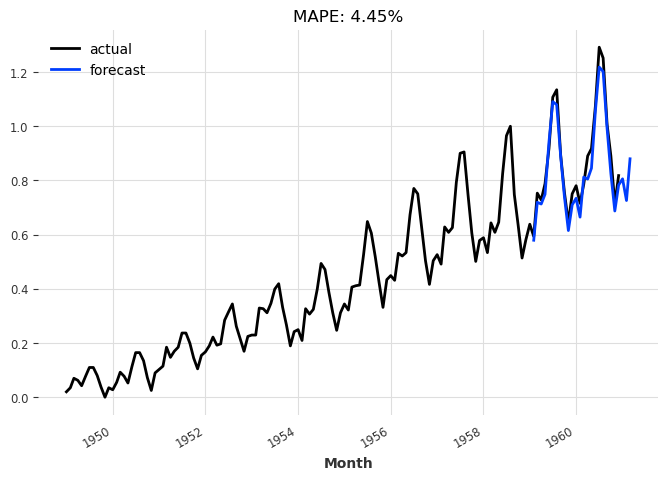

In [42]:
eval_RNN(best_RecurrentNeuralNetwork)

MAPE: 2.52%


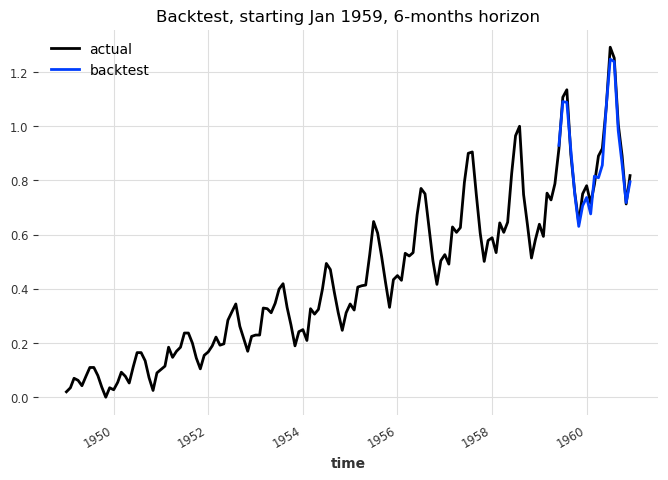

In [43]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_RecurrentNeuralNetwork.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_RecurrentNeuralNetwork),
        )
    )
)

MAPE: 19.89%


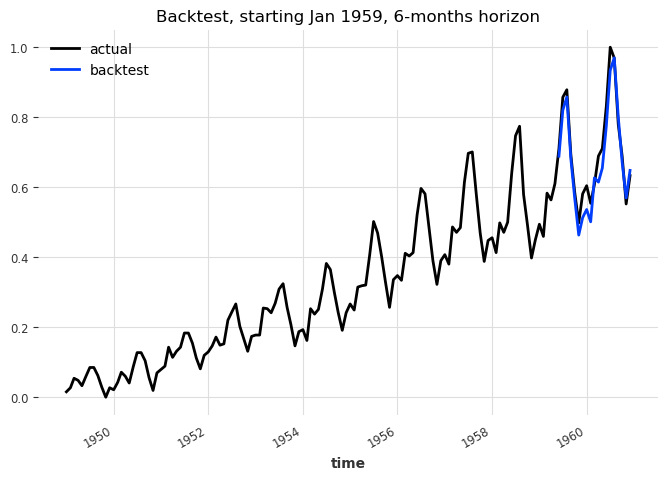

In [44]:
plt.figure(figsize=(8, 5))
ts.plot(label="actual")
backtest_TemporalConvolutionalNetwork.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_TemporalConvolutionalNetwork),
        )
    )
)

Predicting: 0it [00:00, ?it/s]

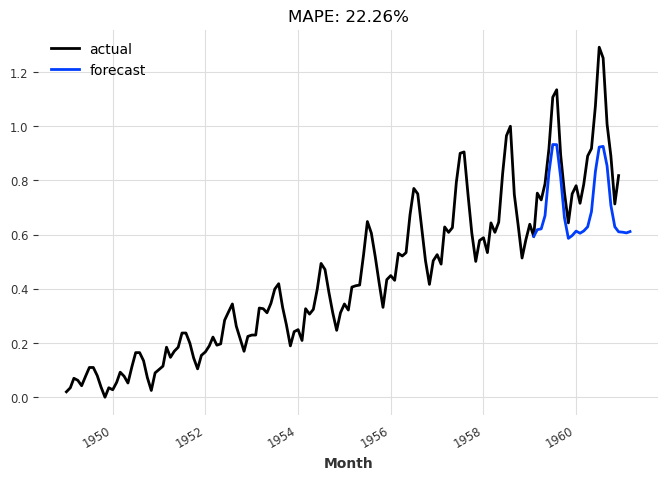

In [51]:
eval_Transformer(Transformer, 26, series_scaled, val_scaled)

Predicting: 0it [00:00, ?it/s]

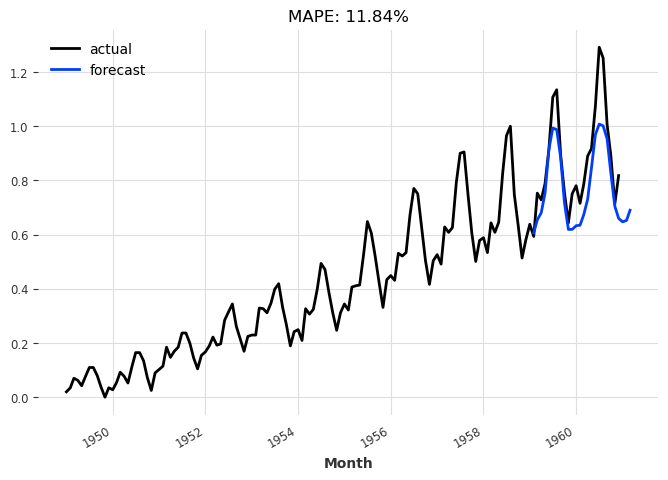

In [52]:
eval_Transformer(bestTransformer, 26, series_scaled, val_scaled)

MAPE: 7.31%


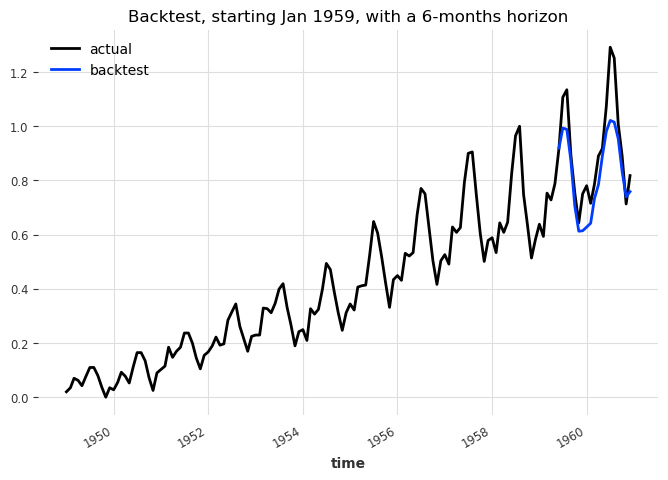

In [53]:
plt.figure(figsize=(8, 5))
series_scaled.plot(label="actual", lw=2)
backtest_series.plot(label="backtest", lw=2)
plt.legend()
plt.title("Backtest, starting Jan 1959, with a 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            scaler.inverse_transform(series_scaled),
            scaler.inverse_transform(backtest_series),
        )
    )
)

Predicting: 0it [00:00, ?it/s]

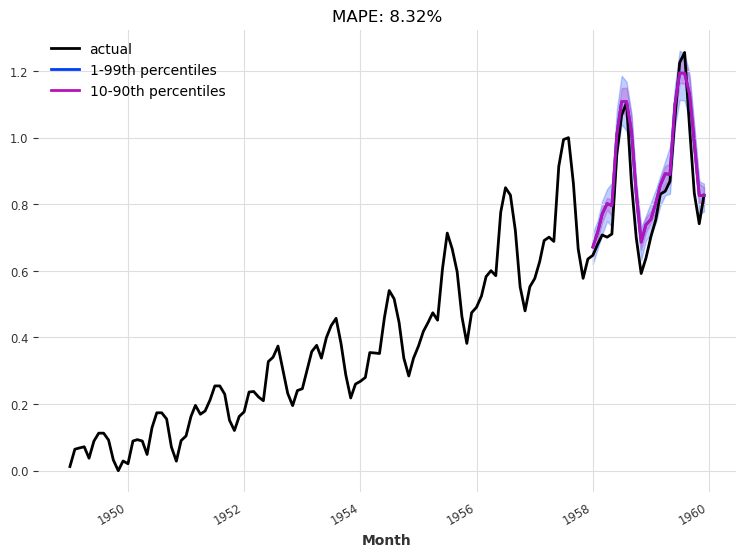

In [64]:
eval_TFT(TemporalFusionTransformer, 24, series_transformed, val_transformed)

MAPE: 5.82%


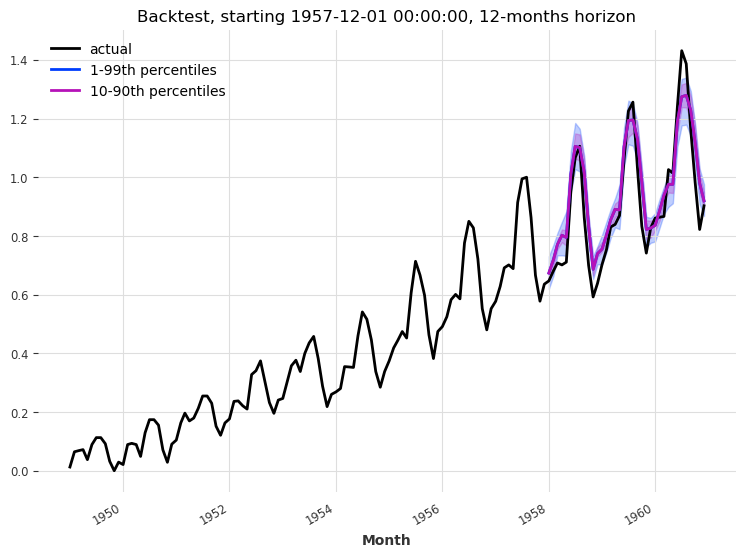

In [63]:
eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff,
    transformer=transformer,
)

# Classic Statistics

In [4]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

simpleExponential_model = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=SeasonalityMode.NONE)
simpleExponential_model.fit(train)
simpleExponential_pred = simpleExponential_model.predict(len(val))

holt_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.NONE)
holt_model.fit(train)
holt_pred = holt_model.predict(len(val))

holtWinters_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
holtWinters_model.fit(train)
holtWinters_pred = holtWinters_model.predict(len(val))

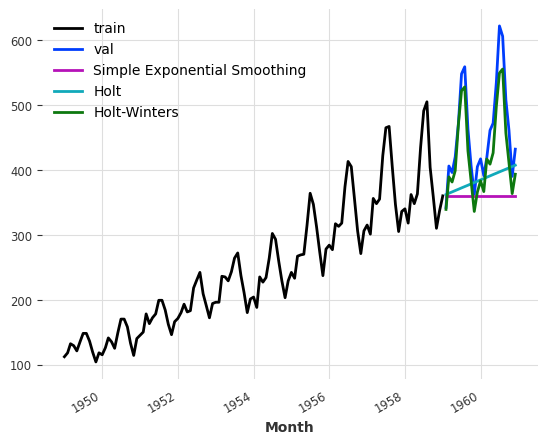

In [9]:
train.plot(label="train")
val.plot(label="val")
simpleExponential_pred.plot(label="Simple Exponential Smoothing")
holt_pred.plot(label="Holt")
holtWinters_pred.plot(label="Holt-Winters")

In [11]:
mapeES = mape(val,simpleExponential_pred)
mapeH = mape(val,holt_pred)
mapeHW = mape(val,holtWinters_pred)
print(mapeES, mapeH, mapeHW)

19.640719439861233 15.085685076919543 6.683917147975793
